<a href="https://colab.research.google.com/github/kavya2299/Image-Enhancement/blob/main/Keras_UNET_Additive_Gaussian_Noise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Experiment description
1. GAUSSIAN ADDITIVE NOISE SIGMA=1
2. Keras framework

# Dataset: 
The data is divided into a training set of 999 images and a test set of 335 images. The size of each 2D ultrasound image is 800 by 540 pixels with a pixel size ranging from 0.052 to 0.326 mm. The images are cropped to 480,736 for training purposes

# Architecture used
#### used denoising Oct UNet architecture
paper link:
https://drive.google.com/file/d/1laxdpyW0z9YUIL-heWSkYZGfCKpVdInr/view?usp=sharing

# Parameters Used:
  1. Optimizer: SGD
  2. LR: 0.01(default for SGD)
  3. No momentum nor adaptive LR
  4. Loss: Bimary_crossentropy
  5. 1019 images used for training(actual data set is 999 but I had faced some problem while organizing them so 20 images have been added redundantly, seeing it to be just20 images i didnt change it so i continued with the same dataset) and for validation 335 test images of HC18 dataset.
  6. epochs=10
  7. batch size=4
  8. The same 1019 images were trained again and again on the network









# Mounting with google drive

In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive') 

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


# IMPORT PACKAGES

In [ ]:
from os import environ
environ['CUDA_VISIBLE_DEVICES'] = '0'
import os
from keras.preprocessing import image
import matplotlib
from PIL import Image
from numpy import *
from scipy import misc
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
from numpy import concatenate
import random
import keras.backend as K
import cv2
from scipy import signal

from keras import layers
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, Activation, concatenate
from keras.models import Model
from keras.layers.normalization import BatchNormalization
import tensorflow as tf

import scipy.misc
import os
import errno

from torchvision.transforms import ToPILImage
from PIL import Image
import imutils
import cv2
import numpy as np
import glob
import matplotlib.pyplot as plt
import random

import os
import time

## these are packages that we need to use to visualize the dataset 
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import pandas as pd

## to make data augmentations
from torchvision.transforms import ToPILImage
from PIL import Image
import imutils
import cv2

## these are basic python packages
import math
import random
import csv

## these are packages that are a part of Pytorch, the deep-learning library
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as TF
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

## these are a few metrics used to make quantitative comparisons
from skimage.measure import compare_ssim
from tabulate import tabulate

#Change the text in experiment variable to store weigts 
from keras.callbacks import ModelCheckpoint
from keras.callbacks import CSVLogger
from keras.callbacks import LambdaCallback
from keras.models import model_from_json

#for Loading the model
from keras.models import load_model

#Load dataset

#load training images and save them as numpy files

they are saved as numpy files just inorder to safe them, so if the notebook disconnects due to any issues we can just load the numpy files

In [ ]:
train_data = []
files = glob.glob ("/content/gdrive/My Drive/Fetal_Imaging/training_set/*.png")

dim=(800,540) 
for myFile in files:
    image = cv2.imread (myFile,0)
    resized = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
    train_data.append (resized)

npfile =np.array(train_data)

file=open('/content/gdrive/My Drive/orig.file','wb')
file.write(npfile)
file.close()

# load train numpy files

In [ ]:
file = open('/content/gdrive/My Drive/orig.file', 'rb')
data = file.read() # The key will be type bytes
file.close()
decoded = np.frombuffer(data,dtype="uint8")
train_data=decoded.reshape((1019, 540, 800))

#load test images  and save them as numpy files

they are saved as numpy files just inorder to safe them, so if the notebook disconnects due to any issues we can just load the numpy files

In [ ]:
test_data = []
files = glob.glob ("/content/gdrive/My Drive/Fetal_Imaging/test_set/*.png")

dim=(800,540) 
for myFile in files:
    image = cv2.imread (myFile,0)
    resized = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
    test_data.append (resized)

npfile =np.array(test_data)
file=open('/content/gdrive/My Drive/test.file','wb')
file.write(npfile)
file.close()


# load test numpy files

In [ ]:
file = open('/content/gdrive/My Drive/test.file', 'rb')
data = file.read() # The key will be type bytes
file.close()
decoded = np.frombuffer(data,dtype="uint8")
test_data=decoded.reshape((335, 540, 800))

# Gaussian additive noise addition function

In [ ]:
def gaussian_additive(x,l,h):#function to add speckle noise
    
    ax= np.copy(x)
    shape=np.shape(ax)
    intensity_noise = np.random.uniform(low=l, high=h)
    ax = ax + intensity_noise*np.random.normal(loc=0, scale=1, size=shape[0]*shape[1]).reshape(shape[0],shape[1])
    return ax

# add speckle to the train_data

In [ ]:
train_data_noise = []
for i in range(train_data.shape[0]):
  new= gaussian_additive(train_data[i],15,20)
  train_data_noise.append (new)
  
train_data_noise =np.array(train_data_noise)

#add speckle to the test_data

In [ ]:
test_data_noise = []
for i in range(test_data.shape[0]):
  new= gaussian_additive(test_data[i],15,20)
  test_data_noise.append (new)
  
test_data_noise =np.array(test_data_noise)

#reshape the data

In [ ]:
train_data=train_data.reshape((1019, 540, 800,1))
test_data=test_data.reshape((335, 540, 800,1))
train_data_noise=train_data_noise.reshape((1019, 540, 800,1))
test_data_noise=test_data_noise.reshape((335, 540, 800,1))

#Pre declarations and variable initialization

In [ ]:
img_rows, img_cols = 480,728
side_crop, top_crop = 36, 30 #to make it divisible by 8 as to avoid dimension mismatch in this network
channels = 1
#num_samples = len(listing1) UPDATE ACCORDINGLY
#idx = random.randint(0, num_samples) WHAT IS THIS

#Remove the borders to get the get the image size divisible bY UNET

In [ ]:
train_data= train_data[:,top_crop:top_crop+img_rows,side_crop:side_crop+img_cols,:]
test_data = test_data[:,top_crop:top_crop+img_rows,side_crop:side_crop+img_cols,:]
train_data_noise= train_data_noise[:,top_crop:top_crop+img_rows,side_crop:side_crop+img_cols,:]
test_data_noise= test_data_noise[:,top_crop:top_crop+img_rows,side_crop:side_crop+img_cols,:]

(1019, 480, 728, 1)
(335, 480, 728, 1)
(1019, 480, 728, 1)
(335, 480, 728, 1)


# sanity check for new data set shapes

In [ ]:
print(train_data.shape)
print(test_data.shape)
print(train_data_noise.shape)
print(test_data_noise.shape)

# Normalize the Data

In [ ]:
train_data = train_data/255.
test_data = test_data/255.
train_data_noise = train_data_noise/255.
test_data_noise = test_data_noise/255.

## Create copy of data
x_clear = np.copy(train_data)
x_noise = np.copy(train_data_noise)
y_clear = np.copy(test_data)
y_noise = np.copy(test_data_noise)

#Architecture Defn

#Standard and residual blocks

In [ ]:
## Defining the Standard and Residual Blocks


def standard_blocks(layer_input, nb_filters, conv_size, dillatation, nb_blocks):
    y = Conv2D(nb_filters, conv_size, dilation_rate = dillatation, padding='same')(layer_input)
    #y = BatchNormalization()(y)
    y = Activation('elu')(y)
    for _ in range(nb_blocks-1):
        y = Conv2D(nb_filters, conv_size, dilation_rate = dillatation, padding='same')(y)
        #y = BatchNormalization()(y)
        y = Activation('elu')(y) 
    return y

def residual_blocks(layer_input, nb_filters, conv_size, dillatation, nb_blocks):
    residual = Conv2D(nb_filters, (1, 1), padding='same', use_bias=False)(layer_input)
    y = Conv2D(nb_filters, conv_size, dilation_rate = dillatation, padding='same')(layer_input)
    y = BatchNormalization()(y)
    y = Activation('elu')(y)
    for _ in range(nb_blocks-1):
        y = Conv2D(nb_filters, conv_size, dilation_rate = dillatation, padding='same')(y)
        y = BatchNormalization()(y)
        y = Activation('elu')(y) 
    y = layers.add([y, residual])
    return y






## Main U-Net Architecture



In [ ]:
def basic_unet(crop_W, crop_H, nb_classes):
    inputs = Input((crop_H, crop_W, 1))
    
    conv1 = standard_blocks(layer_input = inputs, nb_filters = 64, conv_size = (3,3), 
                                  dillatation = 1, nb_blocks=2)
#     pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv_one_1 = Conv2D(64, (1, 1), strides=1, activation='elu', padding='same')(conv1)
    
    pool1 = Conv2D(64, (3, 3), strides=2, activation='elu', padding='same')(conv1)

    conv2 = residual_blocks(layer_input = pool1, nb_filters = 64, conv_size = (3,3), 
                                  dillatation = 2, nb_blocks=2)
    conv_one_2 = Conv2D(64, (1, 1), strides=1, activation='elu', padding='same')(conv2)
    conv_one_2_up = Conv2DTranspose(64, 3, strides=2, padding='same')(conv_one_2)
#     pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    pool2 = Conv2D(64, (3, 3), strides=2, activation='elu', padding='same')(conv2)

    conv3 = residual_blocks(layer_input = pool2, nb_filters = 64, conv_size = (3,3), 
                                  dillatation = 4, nb_blocks=2)
    conv_one_3 = Conv2D(64, (1, 1), strides=1, activation='elu', padding='same')(conv3)
    conv_one_3_up = Conv2DTranspose(64, 3, strides=4, padding='same')(conv_one_3)
#     pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    pool3 = Conv2D(64, (3, 3), strides=2, activation='elu', padding='same')(conv3)

    conv5 = standard_blocks(layer_input = pool3, nb_filters = 64, conv_size = (3,3), 
                                  dillatation = 4, nb_blocks=2)

    up7 = concatenate([Conv2DTranspose(64, 3, strides=2, padding='same')(conv5), conv3], axis=3)

    conv7 = residual_blocks(layer_input = up7, nb_filters = 64, conv_size = (3,3), 
                                  dillatation = 4, nb_blocks=2)
    
    up8 = concatenate([Conv2DTranspose(64, 3, strides=2, padding='same')(conv7), conv2], axis=3)

    conv8 = residual_blocks(layer_input = up8, nb_filters = 64, conv_size = (3,3), 
                                  dillatation = 4, nb_blocks=2)
    
    up9 = concatenate([Conv2DTranspose(64, 3, strides=2, padding='same')(conv8), conv1], axis=3)

    conv9 = standard_blocks(layer_input = up9, nb_filters = 64, conv_size = (3,3), 
                                  dillatation = 1, nb_blocks=2)
    conv9_interm = concatenate([conv9, conv_one_1, conv_one_2_up, conv_one_3_up])
    
#     conv9_interm = concatenate([conv9, conv_one_3], axis = 3)
    conv10 = Conv2D(1, (1, 1))(conv9_interm)
    out = Activation('tanh') (conv10)
    model = Model(inputs=[inputs], outputs=[out])

    return model


## Compile the model and view the summary


In [ ]:
def create_basic_unet():
    print('Compiling model...')
    model = basic_unet(crop_W, crop_H, nb_classes)
    model.compile(optimizer='SGD', loss='binary_crossentropy', metrics=['accuracy'])
    print('Model compiled...')
    return model

#CreateModel

In [ ]:
crop_H, crop_W = img_rows,img_cols #the input shape of the input image
nb_classes = 1 # number of classes
model = create_basic_unet()
model.summary()

Compiling model...
Model compiled...
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 480, 728, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 480, 728, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 480, 728, 64) 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 480, 728, 64) 36928       activation_1[0][0]               
_______________________________________________________

# training settings

In [ ]:
epochs = 10
batch_size = 4

#Training the model

In [ ]:
model.fit(train_data_noise,train_data,
                epochs=epochs,
                batch_size=batch_size,
                shuffle=True,
                validation_data=(test_data_noise,test_data))

Train on 1019 samples, validate on 335 samples
Epoch 1/10
1019/1019 [==============================] - 655s 642ms/step - loss: 0.0329 - accuracy: 0.1395 - val_loss: 0.0157 - val_accuracy: 0.1412
Epoch 2/10
1019/1019 [==============================] - 634s 622ms/step - loss: 0.0143 - accuracy: 0.1401 - val_loss: 0.0130 - val_accuracy: 0.1412
Epoch 3/10
1019/1019 [==============================] - 640s 628ms/step - loss: 0.0126 - accuracy: 0.1401 - val_loss: 0.0128 - val_accuracy: 0.1412
Epoch 4/10
1019/1019 [==============================] - 640s 628ms/step - loss: 0.0118 - accuracy: 0.1401 - val_loss: 0.0141 - val_accuracy: 0.1412
Epoch 5/10
1019/1019 [==============================] - 640s 628ms/step - loss: 0.0116 - accuracy: 0.1401 - val_loss: 0.0121 - val_accuracy: 0.1412
Epoch 6/10
1019/1019 [==============================] - 635s 623ms/step - loss: 0.0114 - accuracy: 0.1401 - val_loss: 0.0107 - val_accuracy: 0.1412
Epoch 7/10
1019/1019 [==============================] - 634s 623m

# save the model

In [ ]:
model.save('/content/gdrive/My Drive/(K)_(denoisingoct)UNET_G additive sigma=1_1.h5')

#load the saved model

In [ ]:
new_model= load_model('/content/gdrive/My Drive/(K)_(denoisingoct)UNET_G additive sigma=1_1.h5')

# prediction

In [ ]:
prediction = new_model.predict(test_data, batch_size=5)

# Result check

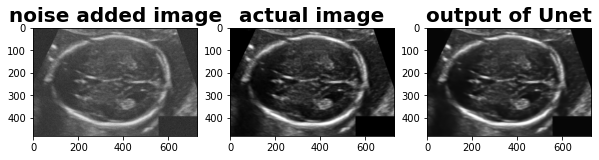

In [ ]:
i=10
x =prediction[i].reshape(480,728)
y= test_data[i].reshape(480,728)
z= test_data_noise[i].reshape(480,728)
#plt.imshow(x,cmap='gray')
plt.figure(figsize=(10,10))

plt.subplot(1,3,1)
plt.title("noise added image",fontweight='bold',size =20)
plt.imshow(z,cmap = 'gray')

plt.subplot(1,3,2)
plt.title("actual image",fontweight='bold',size =20)
plt.imshow(y,cmap = 'gray')

plt.subplot(1,3,3)
plt.title("output of Unet",fontweight='bold',size =20)
plt.imshow(x,cmap = 'gray')